In [54]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from utils import plot_images, train_valid_split
from metric import apk, mapk
import lightgbm as lgb

import faiss
import psutil
from lightfm import LightFM
from scipy import sparse


In [55]:
dataset = '10'

transactions = pd.read_pickle(f"input/{dataset}/transactions_train.pkl")
users = pd.read_pickle(f"input/{dataset}/users.pkl")
items = pd.read_pickle(f"input/{dataset}/items.pkl")
transactions['day'] = (transactions['t_dat'].max() - transactions['t_dat']).dt.days


In [56]:
def lfm(week_start, week_end, target_users):
    NUM_ITEMS = 30
    a = transactions.query("@week_start <= week <= @week_end")
    n_user = len(users)
    n_item = len(items)

    a_train = sparse.lil_matrix((n_user, n_item))
    a_train[a['user'], a['item']] = 1

    no_components = 128
    lightfm_params = {
        'no_components': no_components,
        'learning_schedule': 'adadelta',
        'loss': 'warp',
        'learning_rate': 0.005,
    }

    model = LightFM(**lightfm_params)
    model.fit(a_train, epochs=100, num_threads=psutil.cpu_count(logical=False), verbose=True)
    index = faiss.index_factory(no_components, "Flat", faiss.METRIC_INNER_PRODUCT)
    index = faiss.index_cpu_to_gpu(faiss.StandardGpuResources(), 0, index)
    index.add(model.item_embeddings)
    _, idxs = index.search(model.user_embeddings, NUM_ITEMS)

    return pd.DataFrame({
        'user': np.repeat(target_users, NUM_ITEMS),
        'item': idxs[target_users].flatten(),
        'lfm_rank': list(range(NUM_ITEMS)) * len(target_users),
    })


In [57]:
def create_candidates(transactions: pd.DataFrame, target_users: np.ndarray, week: int) -> pd.DataFrame:
    """
    transactions
        original transactions (user, item, week)
    target_users, week
        候補生成対象のユーザー
        weekで指定されている週の段階での情報のみから作られる
    """
    assert len(target_users) == len(set(target_users))

    def create_candidates_repurchase(
            prefix: str,
            transactions: pd.DataFrame,
            target_users: np.ndarray,
            week_start: int,
            week_end: int) -> pd.DataFrame:
        tr = transactions.query(
            "user in @target_users and @week_start <= week <= @week_end")[['user', 'item', 'week']].drop_duplicates(ignore_index=True)

        gr_week = tr.groupby(['user', 'item'])['week'].min().reset_index(name='week')
        gr_volume = tr.groupby(['user', 'item']).size().reset_index(name='volume')

        gr_week['week_rank'] = gr_week.groupby('user')['week'].rank()
        gr_volume['volume_rank'] = gr_volume.groupby('user')['volume'].rank()

        candidates = gr_week.merge(gr_volume, on=['user', 'item'])
        candidates = candidates[['user', 'item', 'week_rank', 'volume_rank']].rename(
            columns={'week_rank': f'{prefix}_week_rank', 'volume_rank': f'{prefix}_volume_rank'})
        return candidates

    def create_candidates_popular(
            prefix: str,
            transactions: pd.DataFrame,
            target_users: np.ndarray,
            week_start: int,
            week_end: int) -> pd.DataFrame:
        NUM_POPULAR_ITEMS = 24
        tr = transactions.query("@week_start <= week <= @week_end")[['user', 'item']].drop_duplicates(ignore_index=True)
        popular_items = tr['item'].value_counts().index.values[:NUM_POPULAR_ITEMS]
        popular_items = pd.DataFrame({
            'item': popular_items,
            'rank': range(NUM_POPULAR_ITEMS),
            'crossjoinkey': 1,
        })

        candidates = pd.DataFrame({
            'user': target_users,
            'crossjoinkey': 1,
        })

        candidates = candidates.merge(popular_items, on='crossjoinkey').drop('crossjoinkey', axis=1)
        candidates = candidates.rename(columns={'rank': f'{prefix}_rank'})
        return candidates

    def create_candidates_popular_index_group_name(
            prefix: str,
            transactions: pd.DataFrame,
            items: pd.DataFrame,
            target_users: np.ndarray,
            week_start: int,
            week_end: int,
            index_group_name: str) -> pd.DataFrame:
        NUM_POPULAR_ITEMS = 3
        tr = transactions.query("@week_start <= week <= @week_end")[['user', 'item']].drop_duplicates(ignore_index=True)
        tr = tr.merge(items[['item', 'index_group_name']], on='item').query(
            "index_group_name == @index_group_name").drop('index_group_name', axis=1).reset_index(drop=True)

        popular_items = tr['item'].value_counts().index.values[:NUM_POPULAR_ITEMS]
        popular_items = pd.DataFrame({
            'item': popular_items,
            'rank': range(NUM_POPULAR_ITEMS),
            'crossjoinkey': 1,
        })

        candidates = pd.DataFrame({
            'user': target_users,
            'crossjoinkey': 1,
        })

        candidates = candidates.merge(popular_items, on='crossjoinkey').drop('crossjoinkey', axis=1)
        candidates = candidates.rename(columns={'rank': f'{prefix}_rank'})
        return candidates

    def create_candidates_cooc(
            prefix: str,
            transactions: pd.DataFrame,
            week_start: int,
            week_end: int,
            base_candidates: pd.DataFrame) -> pd.DataFrame:
        tr = transactions.query("@week_start <= week == @week_end")[['user', 'item', 'week']].drop_duplicates(ignore_index=True)
        tr = tr.merge(tr.rename(columns={'item': 'item_with', 'week': 'week_with'}), on='user').query(
            "item != item_with and week <= week_with")[['item', 'item_with']].reset_index(drop=True)
        gr_sz = tr.groupby('item').size().reset_index(name='tot')
        gr_cnt = tr.groupby(['item', 'item_with']).size().reset_index(name='cnt')
        item2item = gr_cnt.merge(gr_sz, on='item')
        item2item['ratio'] = item2item['cnt'] / item2item['tot']
        item2item = item2item.query("ratio >= 0.02").reset_index(drop=True)

        base_candidates_columns = [c for c in base_candidates.columns if c not in ['user', 'item', 'week']]
        replace = {c: f"{prefix}_{c}" for c in base_candidates_columns}
        candidates = base_candidates.merge(item2item, on='item').drop(
            ['item', 'cnt'], axis=1).rename(columns={'item_with': 'item'}).rename(columns=replace)
        candidates = candidates.rename(columns={'ratio': f'{prefix}_ratio', 'tot': f'{prefix}_tot'})
        return candidates

    def create_candidates_same_product_code(
            prefix: str,
            items: pd.DataFrame,
            base_candidates: pd.DataFrame) -> pd.DataFrame:
        item2item = items[['item', 'product_code']].merge(items[['item', 'product_code']].rename(
            {'item': 'item_with'}, axis=1), on='product_code')[['item', 'item_with']].query("item != item_with").reset_index(drop=True)

        base_candidates_columns = [c for c in base_candidates.columns if c not in ['user', 'item', 'week']]
        replace = {c: f"{prefix}_{c}" for c in base_candidates_columns}
        candidates = base_candidates.merge(
            item2item,
            on='item').drop(
            'item',
            axis=1).rename(
            columns={
                'item_with': 'item'}).rename(
                    columns=replace)
        return candidates

    candidates = [
        create_candidates_repurchase('repurchase', transactions, target_users, week, week + 3),
        create_candidates_popular('pop', transactions, target_users, week, week),

        # create_candidates_popular_index_group_name(
        #     'pop_ladieswear', transactions, items, target_users, week, week, 'Ladieswear'),
        # create_candidates_popular_index_group_name('pop_divided', transactions, items, target_users, week, week, 'Divided'),
        # create_candidates_popular_index_group_name(
        #     'pop_menswear', transactions, items, target_users, week, week, 'Menswear'),
        # create_candidates_popular_index_group_name('pop_sport', transactions, items, target_users, week, week, 'Sport'),
        # create_candidates_popular_index_group_name(
        #     'pop_baby', transactions, items, target_users, week, week, 'Baby/Children'),
    ]
    candidates.append(create_candidates_cooc('cooc', transactions, week, week + 9, candidates[0]))
    candidates.append(create_candidates_same_product_code('same_product_code', items, candidates[0]))
    # candidates.append(lfm(week, week + 3, target_users))

    volumes = np.array([len(c) for c in candidates])
    print(volumes, volumes / np.sum(volumes))

    return pd.concat(candidates).reset_index(drop=True)


In [58]:
# 評価用
users_1 = transactions[transactions['week'] == 1]['user'].unique()
candidates_1 = create_candidates(transactions, users_1, 2)

# 学習用
users_2 = transactions[transactions['week'] == 2]['user'].unique()
candidates_2 = create_candidates(transactions, users_2, 3)


Epoch: 100%|██████████| 100/100 [00:10<00:00,  9.17it/s]


[ 15655 164160  73970  88114 205200] [0.02861457 0.30005538 0.13520405 0.16105677 0.37506923]


Epoch: 100%|██████████| 100/100 [00:10<00:00,  9.15it/s]


[ 16932 171576  89037  96108 214470] [0.0287899  0.29173489 0.1513918  0.1634148  0.36466862]


In [59]:
def merge_labels(candidates: pd.DataFrame, week: int) -> pd.DataFrame:
    """
    candidates
        (user, item, strategy, score)

    Return
    ------
    (user, item, y, ...)
    """
    labels = transactions[transactions['week'] == week][['user', 'item']].drop_duplicates(ignore_index=True)
    labels['y'] = 1
    original_positives = len(labels)
    labels = candidates.merge(labels, on=['user', 'item'], how='left')
    labels['y'] = labels['y'].fillna(0)
    remaining_positives = labels[['user', 'item', 'y']].drop_duplicates(ignore_index=True)['y'].sum()
    recall = remaining_positives / original_positives
    print(f"Recall: {recall}")
    return labels


In [60]:
labels_1 = merge_labels(candidates_1, 1)
labels_2 = merge_labels(candidates_2, 2)


Recall: 0.09302545661020158
Recall: 0.07715435292036964


In [61]:
def get_query_group(df):
    def run_length_encoding(sequence):
        comp_seq_index, = np.concatenate(([True], sequence[1:] != sequence[:-1], [True])).nonzero()
        return sequence[comp_seq_index[:-1]], np.ediff1d(comp_seq_index)
    users = df['user'].values
    _, group = run_length_encoding(users)
    return list(group)


def postprocess_for_lgbm(labels):
    """
    LightGBMのxendgcやlambdarank用の加工
    * 正例のみや負例のみのuserは学習に無意味なのと、メトリックの計算がおかしくなるので省く
    * userでソートして、データセットに与える必要があるグループを計算する
    user, y
    """
    bef = len(labels)
    df = labels[labels['user'].isin(labels[['user', 'y']].drop_duplicates().groupby(
        'user').size().reset_index(name='sz').query("sz==2").user)].reset_index(drop=True)
    aft = len(df)
    print(f"drop trivial queries: {bef} -> {aft}")

    df = df.sort_values(by='user').reset_index(drop=True)

    group = get_query_group(df)

    return df, group


In [62]:
labels_1['week'] = 1
labels_2['week'] = 2

valid = labels_1.copy()
pred = labels_1.copy()
train = pd.concat([labels_2]).reset_index(drop=True)

valid, group_valid = postprocess_for_lgbm(valid)
train, group_train = postprocess_for_lgbm(train)


drop trivial queries: 547099 -> 146166
drop trivial queries: 588123 -> 141047


In [63]:
item_features = [c for c in items.columns if c.endswith('idx')]
item_features


['product_type_no_idx',
 'product_group_name_idx',
 'graphical_appearance_no_idx',
 'colour_group_code_idx',
 'perceived_colour_value_id_idx',
 'perceived_colour_master_id_idx',
 'department_no_idx',
 'index_code_idx',
 'index_group_no_idx',
 'section_no_idx',
 'garment_group_no_idx']

In [64]:
user_features = ['FN', 'Active', 'age', 'club_member_status_idx', 'fashion_news_frequency_idx']


In [65]:
train = train.merge(items[['item'] + item_features], on='item').merge(users[['user'] + user_features], on='user')
valid = valid.merge(items[['item'] + item_features], on='item').merge(users[['user'] + user_features], on='user')
pred = pred.merge(items[['item'] + item_features], on='item').merge(users[['user'] + user_features], on='user')
len(valid), len(train), len(pred)


(146166, 141047, 547099)

In [66]:
user_dynamic_features_0 = transactions.query("3 <= week <= 8").groupby(
    'user')[['price', 'sales_channel_id']].agg(['mean', 'std'])
user_dynamic_features_1 = transactions.query("2 <= week <= 7").groupby(
    'user')[['price', 'sales_channel_id']].agg(['mean', 'std'])
user_dynamic_features_0.columns = ['user_' + '_'.join(a) for a in user_dynamic_features_0.columns.to_flat_index()]
user_dynamic_features_1.columns = ['user_' + '_'.join(a) for a in user_dynamic_features_1.columns.to_flat_index()]


item_dynamic_features_0 = transactions.query("3 <= week <= 8").groupby(
    'item')[['price', 'sales_channel_id']].agg(['mean', 'std'])
item_dynamic_features_1 = transactions.query("2 <= week <= 7").groupby(
    'item')[['price', 'sales_channel_id']].agg(['mean', 'std'])
item_dynamic_features_0.columns = ['item_' + '_'.join(a) for a in item_dynamic_features_0.columns.to_flat_index()]
item_dynamic_features_1.columns = ['item_' + '_'.join(a) for a in item_dynamic_features_1.columns.to_flat_index()]

train = train.merge(user_dynamic_features_0, on='user', how='left')
valid = valid.merge(user_dynamic_features_1, on='user', how='left')
pred = pred.merge(user_dynamic_features_1, on='user', how='left')

train = train.merge(item_dynamic_features_0, on='item', how='left')
valid = valid.merge(item_dynamic_features_1, on='item', how='left')
pred = pred.merge(item_dynamic_features_1, on='item', how='left')


In [67]:
item_dynamic_features_0 = transactions.query("3 <= week <= 8").merge(users[['user', 'age']], on='user')
item_dynamic_features_0 = item_dynamic_features_0.groupby('item')['age'].agg(['mean', 'std'])
item_dynamic_features_0.columns = [f'age_{a}' for a in item_dynamic_features_0.columns.to_flat_index()]

item_dynamic_features_1 = transactions.query("2 <= week <= 7").merge(users[['user', 'age']], on='user')
item_dynamic_features_1 = item_dynamic_features_1.groupby('item')['age'].agg(['mean', 'std'])
item_dynamic_features_1.columns = [f'age_{a}' for a in item_dynamic_features_1.columns.to_flat_index()]

train = train.merge(item_dynamic_features_0, on='item', how='left')
valid = valid.merge(item_dynamic_features_1, on='item', how='left')
pred = pred.merge(item_dynamic_features_1, on='item', how='left')


In [68]:
weeks_0 = transactions.query("week >= 3").groupby('item')['week'].min().reset_index(name='item_week_min')
weeks_0['item_week_min'] -= 3
counts_0 = transactions.query("3 <= week <= 3").groupby('item').size().reset_index(name='item_volume')

train = train.merge(weeks_0, on='item', how='left').merge(counts_0, on='item', how='left')

weeks_1 = transactions.query("week >= 2").groupby('item')['week'].min().reset_index(name='item_week_min')
weeks_1['item_week_min'] -= 2
counts_1 = transactions.query("2 <= week <= 2").groupby('item').size().reset_index(name='item_volume')

valid = valid.merge(weeks_1, on='item', how='left').merge(counts_1, on='item', how='left')
pred = pred.merge(weeks_1, on='item', how='left').merge(counts_1, on='item', how='left')


In [69]:
hoge = transactions.query("week >= 3").groupby(['user', 'item'])['week'].min().reset_index(name='user_item_week_min')
hoge['user_item_week_min'] -= 3
train = train.merge(hoge, on=['user', 'item'], how='left')

hoge = transactions.query("week >= 2").groupby(['user', 'item'])['week'].min().reset_index(name='user_item_week_min')
hoge['user_item_week_min'] -= 2
valid = valid.merge(hoge, on=['user', 'item'], how='left')
pred = pred.merge(hoge, on=['user', 'item'], how='left')


In [70]:
hoge = transactions.query("3 <= week <= 3").groupby(['user', 'item']).size().reset_index(name='user_item_volume')
train = train.merge(hoge, on=['user', 'item'], how='left')

hoge = transactions.query("2 <= week <= 2").groupby(['user', 'item']).size().reset_index(name='user_item_volume')
valid = valid.merge(hoge, on=['user', 'item'], how='left')
pred = pred.merge(hoge, on=['user', 'item'], how='left')


In [71]:
feature_columns = [c for c in train.columns if c not in ['y', 'week']]
print(feature_columns)


['user', 'item', 'repurchase_week_rank', 'repurchase_volume_rank', 'pop_rank', 'cooc_repurchase_week_rank', 'cooc_repurchase_volume_rank', 'cooc_tot', 'cooc_ratio', 'same_product_code_repurchase_week_rank', 'same_product_code_repurchase_volume_rank', 'lfm_rank', 'product_type_no_idx', 'product_group_name_idx', 'graphical_appearance_no_idx', 'colour_group_code_idx', 'perceived_colour_value_id_idx', 'perceived_colour_master_id_idx', 'department_no_idx', 'index_code_idx', 'index_group_no_idx', 'section_no_idx', 'garment_group_no_idx', 'FN', 'Active', 'age', 'club_member_status_idx', 'fashion_news_frequency_idx', 'user_price_mean', 'user_price_std', 'user_sales_channel_id_mean', 'user_sales_channel_id_std', 'item_price_mean', 'item_price_std', 'item_sales_channel_id_mean', 'item_sales_channel_id_std', 'age_mean', 'age_std', 'item_week_min', 'item_volume', 'user_item_week_min', 'user_item_volume']


In [72]:
train_dataset = lgb.Dataset(train[feature_columns], train['y'], group=group_train)
valid_dataset = lgb.Dataset(valid[feature_columns], valid['y'], group=group_valid, reference=train_dataset)


In [73]:
params = {
    'objective': 'xendcg',
    'boosting_type': 'gbdt',
    'learning_rate': 1e-3,
    'num_leaves': 255,
    'min_data_in_leaf': 100,
    'metric': 'map',
    'eval_at': 12,
}

model = lgb.train(
    params, train_dataset, valid_sets=[
        train_dataset, valid_dataset], num_boost_round=1000, callbacks=[
            lgb.early_stopping(10)])


[LightGBM] [Info] Total groups: 1354, total data: 141047
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005866 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4255
[LightGBM] [Info] Number of data points in the train set: 141047, number of used features: 42
[LightGBM] [Info] Total groups: 1442, total data: 146166
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[67]	training's map@12: 0.575268	valid_1's map@12: 0.453445


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

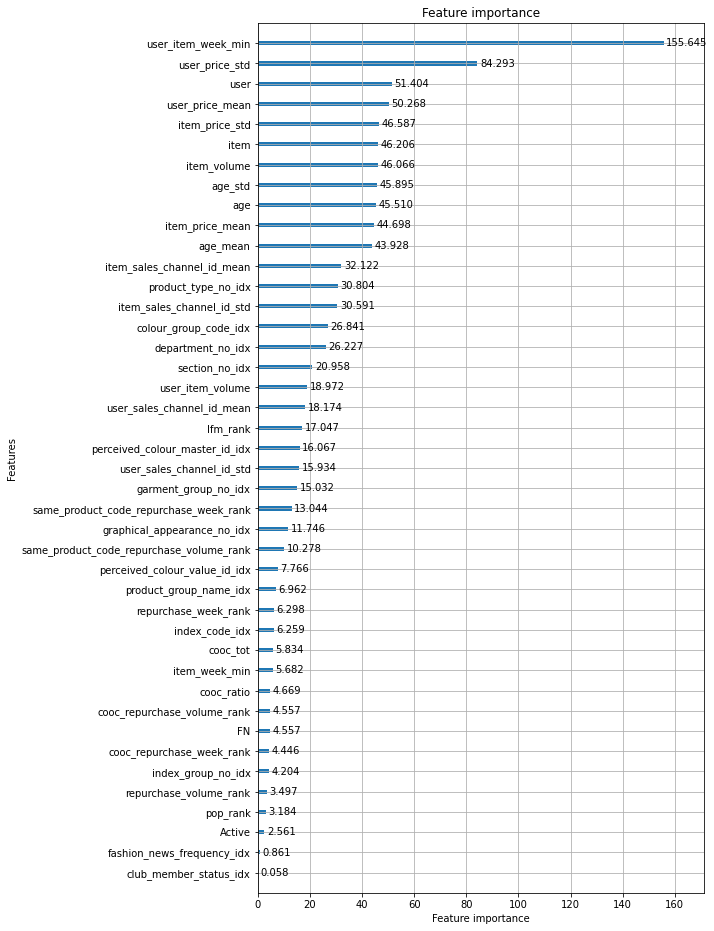

In [74]:
lgb.plot_importance(model, importance_type='gain', figsize=(8, 16))


In [75]:
# recent_items = transactions.query("2 <= week <= 4").item.unique()
# pred = pred.query("item in @recent_items")


In [76]:
pred['pred'] = model.predict(pred[feature_columns], num_iteration=model.best_iteration)
pred_user_item_pred = pred.groupby(['user', 'item'])['pred'].max().reset_index()


In [77]:
pred_user_item_pred = pred_user_item_pred.sort_values(by=['user', 'pred'], ascending=False).reset_index(
    drop=True).groupby('user')['item'].apply(lambda x: list(x)[:12]).reset_index()
pred_user_item_pred


,user,item
0,15,"[82298, 75431, 85628, 80136, 38799, 79182, 754..."
1,34,"[57699, 85085, 84911, 54624, 85434, 2433, 4262..."
2,64,"[42628, 1772, 81424, 5631, 71832, 44138, 57699..."
3,83,"[85434, 57699, 85105, 85085, 84911, 83369, 546..."
4,140,"[81769, 81770, 81771, 85105, 57699, 45117, 850..."
...,...,...
6835,137072,"[58031, 64274, 66287, 79986, 84503, 81890, 104..."
6836,137085,"[32617, 85106, 67752, 45435, 85365, 45117, 243..."
6837,137111,"[85106, 84911, 83369, 85434, 85085, 54624, 849..."
6838,137165,"[35943, 63768, 85106, 45117, 35966, 84522, 849..."


In [78]:
gt = transactions[transactions['week'] == 1].groupby('user')['item'].apply(list).reset_index().rename(columns={'item': 'gt'})
merged = gt.merge(pred_user_item_pred, on='user', how='left')
merged['item'] = merged['item'].fillna('').apply(list)
merged


,user,gt,item
0,15,"[69908, 84841]","[82298, 75431, 85628, 80136, 38799, 79182, 754..."
1,34,"[56357, 83990, 85848]","[57699, 85085, 84911, 54624, 85434, 2433, 4262..."
2,64,"[349, 10062, 17692, 2757, 84814, 83213, 83613,...","[42628, 1772, 81424, 5631, 71832, 44138, 57699..."
3,83,"[55271, 55270]","[85434, 57699, 85105, 85085, 84911, 83369, 546..."
4,140,[71807],"[81769, 81770, 81771, 85105, 57699, 45117, 850..."
...,...,...,...
6835,137072,"[77848, 80462]","[58031, 64274, 66287, 79986, 84503, 81890, 104..."
6836,137085,"[79577, 79577]","[32617, 85106, 67752, 45435, 85365, 45117, 243..."
6837,137111,[39001],"[85106, 84911, 83369, 85434, 85085, 54624, 849..."
6838,137165,"[85679, 85156]","[35943, 63768, 85106, 45117, 35966, 84522, 849..."


In [79]:
mapk(merged['gt'], merged['item'])


0.027015595293264295

In [80]:
popular_items = transactions[transactions['week'] == 2]['item'].value_counts()[:12].index.tolist()
merged['item'] = merged['item'].apply(lambda x: x + popular_items)
mapk(merged['gt'], merged['item'])


0.027015595293264295